# Exploring the Lovecraft Corpus - Topic Modeling  
Ryan Folks  
vcz2aj@virginia.edu  

### Objective: The objective of this notebook is to apply [latent dirichlet allocation](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation) to the lovecraft corpus.
---

## Libraries

In [325]:
import pandas as pd
import numpy as np
from sklearn.decomposition import LatentDirichletAllocation as LDA, NMF
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

## Prepare Data

In [246]:
np.random.seed(5)
n_terms = 1000
n_topics = 15 # lovecraft's work isn't varied enough for too many topics. More than 10 and there might be story-specific topics.
max_iter = 20
# n_top_terms = 7
doc_topic_prior = .1 # Prior of document topic distribution alpha. Defaults to 1 / n_components.
topic_word_prior = .1 # Prior of topic word distribution beta. Defaults to 1 / n_components.

In [293]:
data_home = 'data'
data_prefix = 'lovecraft_'
BAG = ['title']
BOW = pd.read_csv(f'{data_home}/output/{data_prefix}BOW.csv').set_index(BAG+['term_str'])
LIB = pd.read_csv(f'{data_home}/output/{data_prefix}LIB.csv').set_index('title')

In [248]:
class TopicModel():            

    bow_count_col:str = 'n'
    n_topics:int = 20
    n_top_terms:int = None
    engine_type = 'LDA' # Also NMF
    n_terms = 1000

    # LDA Params
    max_iter:int = 20
    learning_offset:float = 50.
    random_state:int = 0
    
    # NMF Params
    nmf_init = 'nndsvd'
    nmf_max_iter = 1000
    
    def __init__(self, BOW:pd.DataFrame):
        self.BOW = BOW
        self.LIB = LIB
        
    def create_X(self):
        X = self.BOW[self.bow_count_col].unstack()
        V = X.count().to_frame('df')
        X = X.fillna(0)
        V['idf'] = np.log2(len(X)/V.df)
        V['dfidf'] = V.df * V.idf
        SIGS = V.sort_values('dfidf', ascending=False).head(self.n_terms).index
        self.X = X[SIGS]
        self.V = V              
        
    def get_model(self):
        
        if self.engine_type == 'LDA':
            self.engine = LDA(n_components=self.n_topics, 
                                  max_iter=self.max_iter, 
                                  learning_offset=self.learning_offset, 
                                  random_state=self.random_state)

        elif self.engine_type == 'NMF':
            self.engine = NMF(n_components=self.n_topics, 
                                  max_iter=self.nmf_max_iter,
                                  init=self.nmf_init, 
                                  random_state=1, 
                                  alpha=.1, 
                                  l1_ratio=.5)
                
        self.THETA = pd.DataFrame(self.engine.fit_transform(self.X.values), index=self.X.index)
        self.THETA.columns.name = 'topic_id'
        
        self.PHI = pd.DataFrame(self.engine.components_, columns=self.X.columns)
        self.PHI.index.name = 'topic_id'
        self.PHI.columns.name = 'term_str'
        
        self.TOPIC = self.PHI.sum(1).to_frame('phi_sum')
        self.TOPIC['theta_sum'] = self.THETA.sum()

    def describe_topics(self):
        
        PHI_P = (self.PHI.T / self.PHI.T.sum())
        PHI_I = np.log2(1/PHI_P)
        self.TOPIC['h'] = round((PHI_I * PHI_P).sum().sort_values(ascending=False), 2)
        if not self.n_top_terms:
            self.n_top_terms = round(self.TOPIC.h.mean())
            
        # Compute relevant terms
        self.get_relevant_terms(0)            

        self.TOPIC['top_terms'] = self.PHI.stack().to_frame('topic_weight')\
            .groupby('topic_id')\
            .apply(lambda x: 
                x.sort_values('topic_weight', ascending =False)\
                    .head(self.n_top_terms)\
                    .reset_index()['term_str'])\
            .apply(lambda x: ' '.join(x.replace(' ', '_')), 1)
        
        # Not using top terms from above; using from get_relevant_terms()
        self.TOPIC['label'] = self.TOPIC.apply(lambda x: f"{x.name}: {x.top_terms_rel}", 1)
                
    def get_relevant_terms(self, 𝜆 = .5):
        """
        Compute relevance of topic terms as defined by Sievert and Shirley 2014.
        C. Sievert and K. Shirley, “LDAvis: A Method for Visualizing and Interpreting Topics,” 
        in Proceedings of the workshop on interactive language learning, visualization, and interfaces, 2014, pp. 63–70.
        """
        Ptw = self.PHI.apply(lambda x: x / x.sum(), 1) # L1 norm of PHI rows, i.e. p(w|t)
        Pw = self.PHI.sum() / self.PHI.sum().sum() # Marginal probs of terms in PHI, i.e. p(w)
        self.REL = 𝜆 * np.log2(Ptw) + (1-𝜆) * np.log2(Ptw / Pw)
        self.TOPIC['top_terms_rel'] = self.REL.apply(lambda x: ' '.join(x.sort_values(ascending=False).head(self.n_top_terms).index), 1)

    def get_model_stats(self):
        # p = self.TOPIC.theta_sum / self.TOPIC.theta_sum.sum()
        self.entropy = self.TOPIC.h.sum()
        self.redundancy = 1 - self.entropy / np.log2(self.n_topics)
    
    def get_doc_stats(self):
        self.DOC = (self.THETA.T * np.log2(1/self.THETA.T)).sum().to_frame('entropy')
        self.DOC['max_topic'] = self.THETA.idxmax(1)
        
    def plot_topics(self):
        self.TOPIC.sort_values('theta_sum', ascending=True).plot.barh(y='theta_sum', x='label', figsize=(5, self.n_topics/2))

## Make Model

In [249]:
BOW

n        tf     tfidf
title                term_str                             
a garden             !               1  0.004566  0.000822
                     ,              13  0.059361  0.000000
                     .               4  0.018265  0.000147
                     :               2  0.009132  0.002571
                     ;               2  0.009132  0.000148
...                                 ..       ...       ...
what the moon brings would           2  0.002635  0.000443
                     writhing        1  0.001318  0.001174
                     yellow          2  0.002635  0.001403
                     yellow-litten   1  0.001318  0.002684
                     yet             1  0.001318  0.000199

[130334 rows x 3 columns]

In [250]:
tm_hp = TopicModel(BOW)
tm_hp.n_topics = n_topics
tm_hp.engine_type = 'LDA'
tm_hp.create_X()
tm_hp.get_model()
tm_hp.describe_topics()
tm_hp.get_model_stats()
tm_hp.get_doc_stats()

In [251]:
tm_hp.DOC = BOW.groupby(['title']).n.sum().to_frame().join(LIB['category'])
tm_hp.DOC['label'] = tm_hp.DOC.apply(lambda x: f"{x.name[:30]} ({x.category[:1]})", 1)

In [252]:
tm_hp.DOC

,n,category,label
title,,,
a garden,219,poem,a garden (p)
an american to mother england,581,poem,an american to mother england (p)
arcadia,87,poem,arcadia (p)
astrophobos,291,poem,astrophobos (p)
at the mountains of madness,45410,short story,at the mountains of madness (s)
...,...,...,...
"to clark ashton smith, esq., upon his phantastick tales, verses, pictures, and sculptures",132,poem,"to clark ashton smith, esq., u (p)"
"to edward john moreton drax plunkett, eighteenth baron dunsany",613,poem,to edward john moreton drax pl (p)
"unda; or, the bride of the sea",817,poem,"unda; or, the bride of the sea (p)"


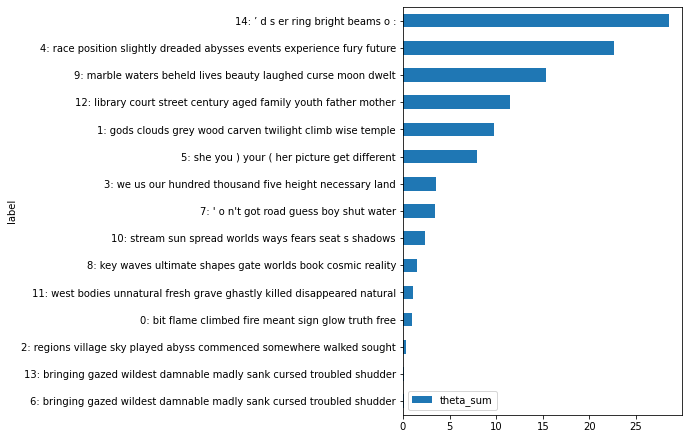

In [253]:
tm_hp.plot_topics()

In [254]:
HP_IMG = tm_hp.THETA.groupby('title').mean()
HP_IMG.index = tm_hp.DOC.label
HP_IMG.columns = tm_hp.TOPIC.label

Take out topic 1 and softmax the rest.

In [255]:
def normalize_line(series):
    return series/np.sum(series)

In [360]:
temp_img = HP_IMG.copy()
temp_img.drop(columns = '14: ’ d s er ring bright beams o :', inplace=True)
temp_img = temp_img.apply(lambda x: normalize_line(x), axis=1)
temp_img

label,0: bit flame climbed fire meant sign glow truth free,1: gods clouds grey wood carven twilight climb wise temple,2: regions village sky played abyss commenced somewhere walked sought,3: we us our hundred thousand five height necessary land,4: race position slightly dreaded abysses events experience fury future,5: she you ) your ( her picture get different,6: bringing gazed wildest damnable madly sank cursed troubled shudder,7: ' o n't got road guess boy shut water,8: key waves ultimate shapes gate worlds book cosmic reality,9: marble waters beheld lives beauty laughed curse moon dwelt,10: stream sun spread worlds ways fears seat s shadows,11: west bodies unnatural fresh grave ghastly killed disappeared natural,12: library court street century aged family youth father mother,13: bringing gazed wildest damnable madly sank cursed troubled shudder
title,,,,,,,,,,,,,,
a garden (p),0.071428,0.071429,0.071428,0.071429,0.071429,0.071429,0.071428,0.071429,0.071429,0.071429,0.071429,0.071429,0.071429,0.071428
an american to mother england (p),0.007389,0.007389,0.007389,0.007389,0.007389,0.007389,0.007389,0.007389,0.007389,0.551563,0.007389,0.359769,0.007389,0.007389
arcadia (p),0.003937,0.003937,0.003937,0.003937,0.003937,0.003937,0.003937,0.389682,0.003937,0.003937,0.059034,0.003937,0.507977,0.003937
astrophobos (p),0.071429,0.071429,0.071428,0.071429,0.071429,0.071429,0.071428,0.071429,0.071429,0.071429,0.071429,0.071429,0.071429,0.071428
at the mountains of madness (s),0.000007,0.002058,0.000007,0.674880,0.319430,0.003560,0.000007,0.000007,0.000007,0.000007,0.000007,0.000007,0.000007,0.000007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"to clark ashton smith, esq., u (p)",0.003970,0.948390,0.003970,0.003970,0.003970,0.003970,0.003970,0.003970,0.003970,0.003970,0.003970,0.003970,0.003970,0.003970
to edward john moreton drax pl (p),0.001800,0.336379,0.001800,0.221149,0.001800,0.001800,0.001800,0.001800,0.001800,0.422676,0.001800,0.001800,0.001800,0.001800
"unda; or, the bride of the sea (p)",0.071428,0.071429,0.071429,0.071429,0.071429,0.071429,0.071428,0.071429,0.071429,0.071429,0.071429,0.071429,0.071429,0.071428


In [361]:
temp_img.T.style.background_gradient(cmap='GnBu')

title,a garden (p),an american to mother england (p),arcadia (p),astrophobos (p),at the mountains of madness (s),azathoth (s),beyond the wall of sleep (s),celephais (s),christmas (p),cool air (s),dagon (s),dead passion's flame (p),despair (p),ex oblivione (s),fact and fancy (p),facts concerning the late arth (s),festival (p),from beyond (s),fungi from yuggoth (p),hallowe'en in a suburb (p),he (s),herbert west: reanimator (s),hypnos (s),imprisoned with the pharaohs (s),in a sequester’d providence ch (p),in the vault (s),laeta; a lament (p),life’s mystery (p),lines on gen. robert edward le (p),medusa's coil (s),memory (s),nathicana (p),nemesis (p),nyarlathotep (s),"ode for july fourth, 1917 (p)",on reading lord dunsany’s book (p),on receiving a picture of swan (p),pacifist war song—1917 (p),pickman's model (s),"poemata minora, volume ii (p)",poetry and the gods (s),polaris (s),providence (p),psychopompos (p),revelation (p),sunset (p),the alchemist (s),the ancient track (p),the beast in the cave (s),the book (s),the call of cthulhu (s),the case of charles dexter war (s),the cats (p),the cats of ulthar (s),the city (p),the colour out of space (s),the conscript (p),the crawling chaos (s),the descendant (s),the doom that came to sarnath (s),the dream-quest of unknown kad (s),the dreams in the witch house (s),the dunwich horror (s),the evil clergyman (s),the festival (s),the haunter of the dark (s),the horror at martin's beach (s),the horror at red hook (s),the hound (s),the house (p),the lurking fear (s),the messenger (p),the moon-bog (s),the music of erich zann (s),the nameless city (s),the nightmare lake (p),the other gods (s),the outpost (p),the outsider (s),the peace advocate (p),the picture in the house (s),the poe-et’s nightmare (p),the quest of iranon (s),the rats in the walls (s),the rose of england (p),the shadow out of time (s),the shadow over innsmouth (s),the shunned house (s),the silver key (s),the statement of randolph cart (s),the strange high house in the (s),the street (s),the temple (s),the terrible old man (s),the thing on the doorstep (s),the tomb (s),the transition of juan romero (s),the tree (s),the unnamable (s),the very old folk (s),the whisperer in darkness (s),the white ship (s),the wood (p),through the gates of the silve (s),"to clark ashton smith, esq., u (p)",to edward john moreton drax pl (p),"unda; or, the bride of the sea (p)",waste paper a poem of profound (p),what the moon brings (s)
label,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0: bit flame climbed fire meant sign glow truth free,0.071428,0.007389,0.003937,0.071429,0.000007,0.000556,0.000073,0.000132,0.071428,0.000102,0.000140,0.071428,0.006471,0.000407,0.005020,0.000087,0.071429,0.000091,0.000079,0.003622,0.000076,0.000025,0.000106,0.000031,0.005186,0.000098,0.071428,0.004785,0.005661,0.000016,0.000717,0.071428,0.002896,0.000246,0.005674,0.009748,0.071429,0.002364,0.000049,0.002229,0.000167,0.000201,0.001390,0.000663,0.015315,0.009908,0.000086,0.001314,0.000134,0.000237,0.000029,0.000007,0.003560,0.000251,0.002277,0.000024,0.002156,0.000102,0.000219,0.000141,0.000008,0.000021,0.000017,0.000156,0.000094,0.000033,0.000134,0.000045,0.000099,0.003129,0.000043,0.964979,0.000092,0.000089,0.000061,0.002377,0.000154,0.000750,0.000111,0.071429,0.000088,0.071428,0.000116,0.000041,0.008926,0.000012,0.000011,0.000030,0.000064,0.000109,0.000084,0.000148,0.000059,0.000307,0.000025,0.000082,0.000115,0.000250,0.000102,0.000132,0.000011,0.000126,0.002888,0.000021,0.003970,0.001800,0.071428,0.000562,0.000454
1: gods clouds grey wood carven twilight climb wise temple,0.071429,0.007389,0.003937,0.071429,0.002058,0.206976,0.000073,0.259230,0.071429,0.000102,0.000140,0.071428,0.915871,0.000407,0.005020,0.000087,0.071429,0.000091,0.479112,0.434724,0.102961,0.000025,0.000106,0.076080,0.005186,0.000098,0.071429,0.004785,0.005661,0.000016,0.000717,0.071429,0.002896,0.287921,0.005674,0.009748,0.071429,0.00

In [262]:
tm_hp.TOPIC

,phi_sum,theta_sum,h,top_terms_rel,top_terms,label
topic_id,,,,,,
0,90.479409,0.965543,9.27,bit flame climbed fire meant sign glow truth free,bit meant elder ago tried climbed door sign hill,0: bit flame climbed fire meant sign glow trut...
1,9700.869923,9.808225,8.78,gods clouds grey wood carven twilight climb wi...,gods city earth grey way even sea stone cold,1: gods clouds grey wood carven twilight climb...
2,167.046875,0.304651,7.71,regions village sky played abyss commenced som...,sky village city abyss sea dreams regions drea...,2: regions village sky played abyss commenced ...
3,8743.158250,3.492222,8.01,we us our hundred thousand five height necessa...,we our us even land city feet course ``,3: we us our hundred thousand five height nece...
4,37112.550061,22.670833,9.48,race position slightly dreaded abysses events ...,even certain felt thought most since two almost ?,4: race position slightly dreaded abysses even...
5,16975.118940,7.894148,8.75,she you ) your ( her picture get different,you `` she her do n't ? '' even,5: she you ) your ( her picture get different
6,66.666667,0.083552,9.97,bringing gazed wildest damnable madly sank cur...,future deeper wildest hint pit magic cut remai...,6: bringing gazed wildest damnable madly sank ...
7,7890.544783,3.431970,8.05,' o n't got road guess boy shut water,' n't o `` ... do ? kind got,7: ' o n't got road guess boy shut water
8,2510.942345,1.479261,8.11,key waves ultimate shapes gate worlds book cos...,`` you '' key ? earth has dreams being,8: key waves ultimate shapes gate worlds book ...


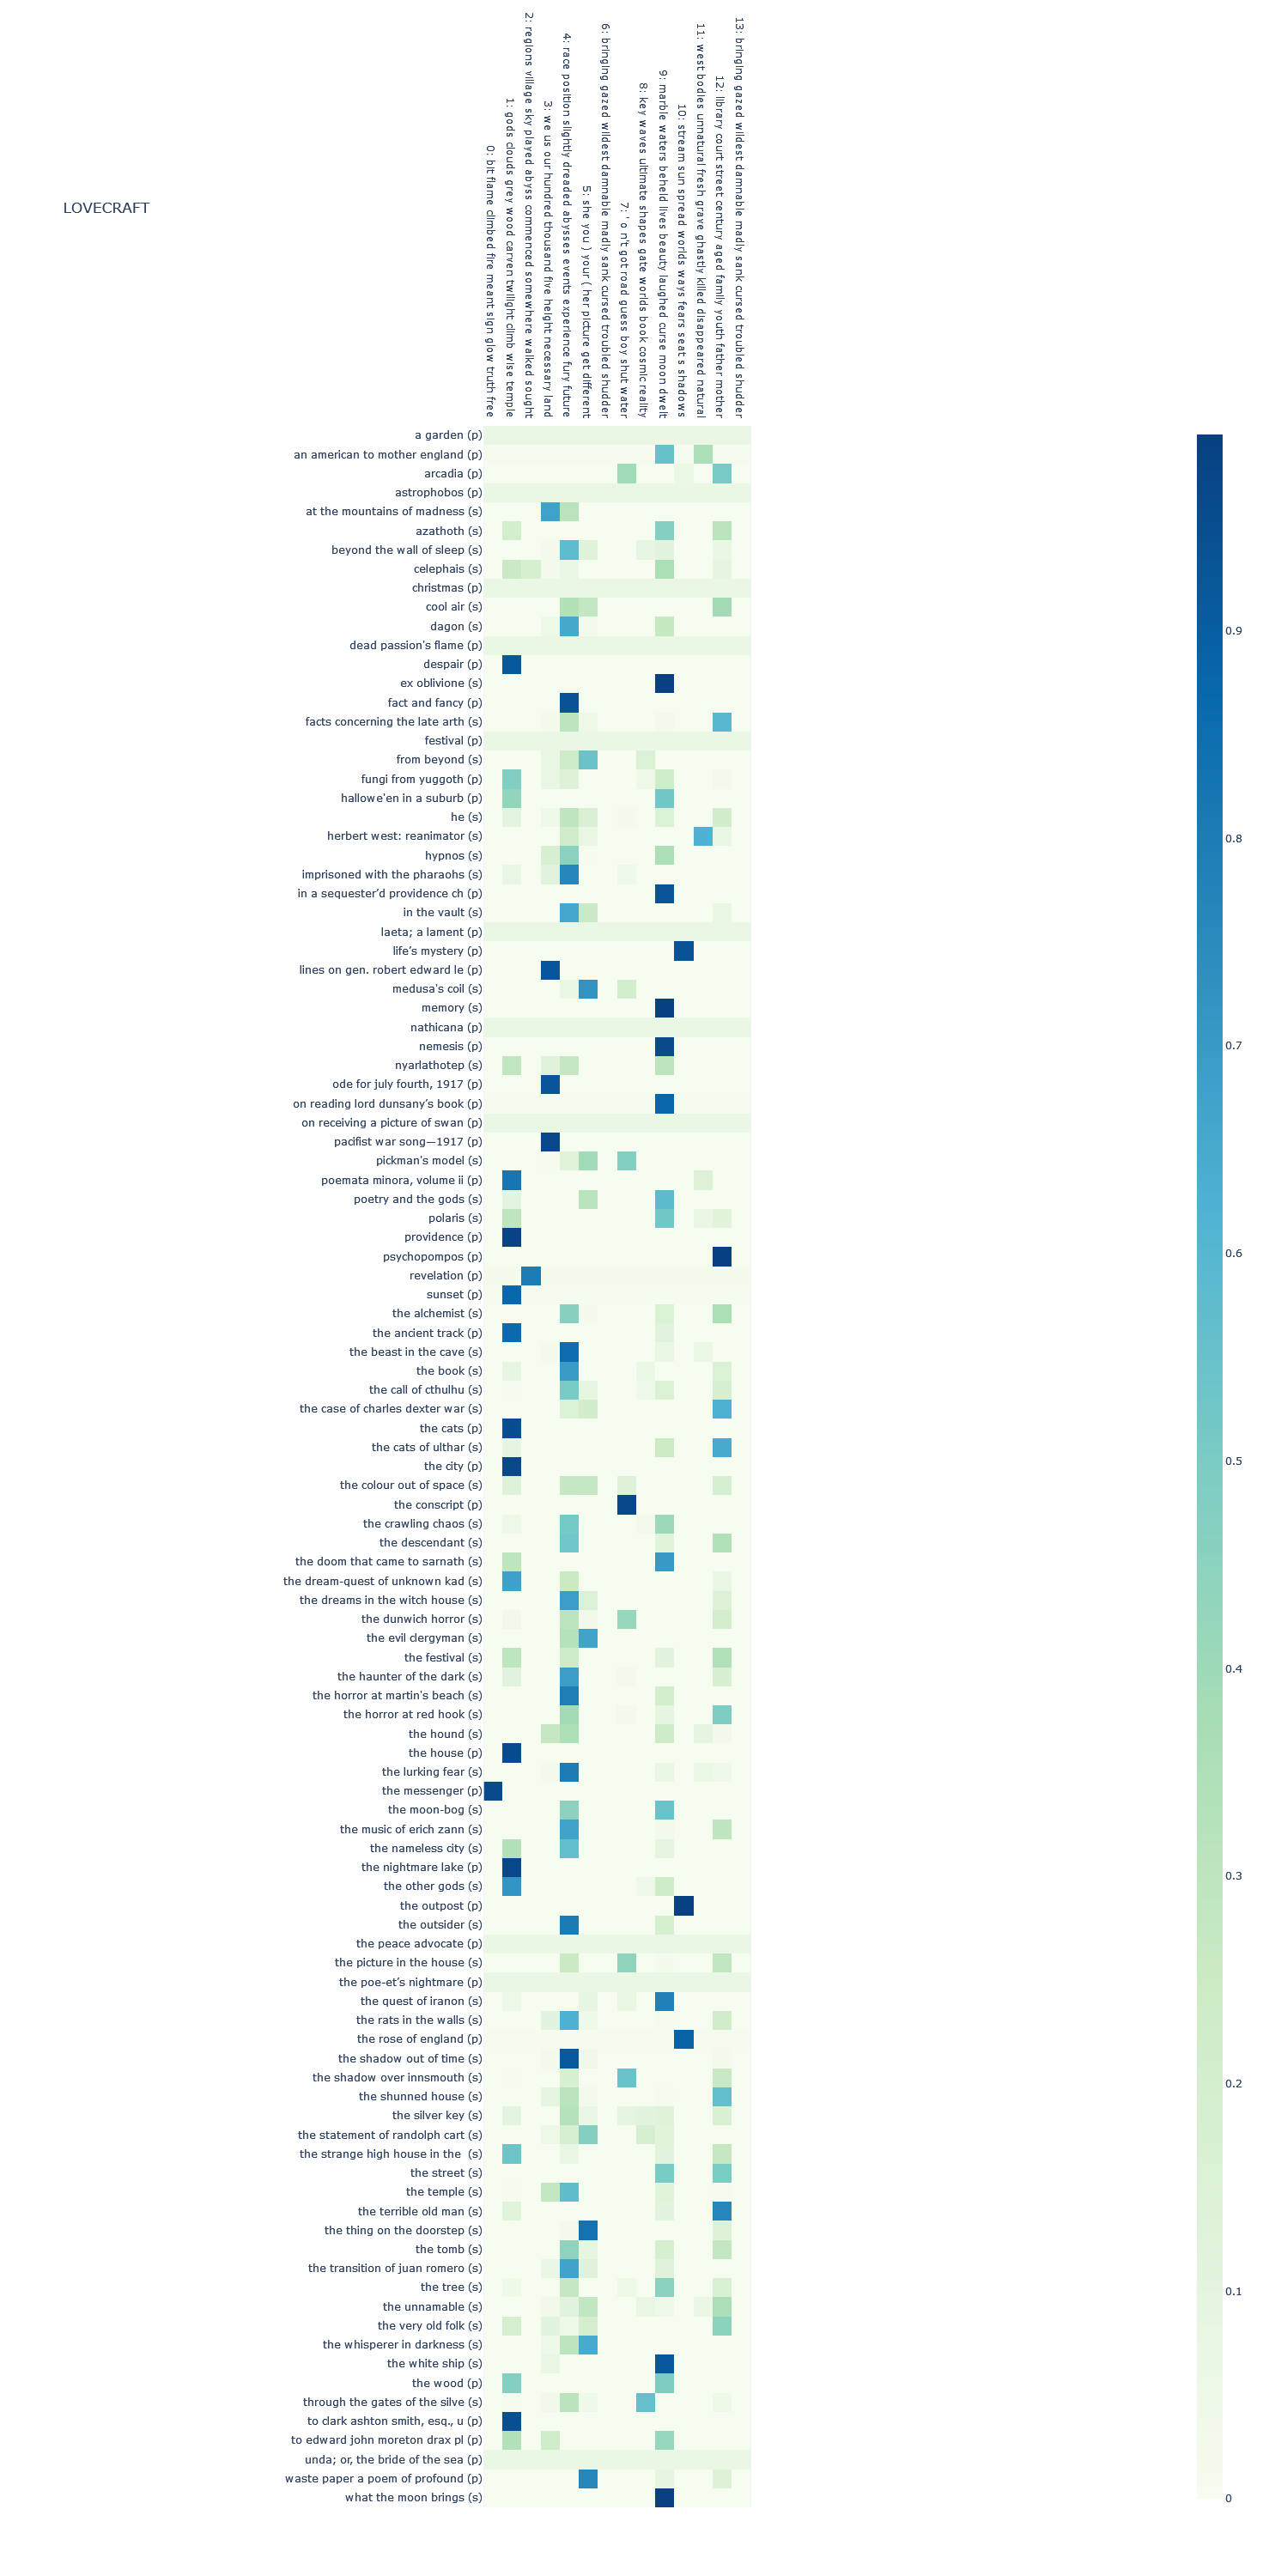

In [362]:
fig = px.imshow(temp_img, color_continuous_scale='GnBu', title="LOVECRAFT", height=3000, width=1000)
fig.update_layout(xaxis={'side': 'top', 'title_text':None}, yaxis={'title_text':None},)

## Topics Across Time

In [264]:
LIB

,filepath,date,category
title,,,
the alchemist,data/short_stories\alchemist.txt,1908,short story
facts concerning the late arthur jermyn and his family,data/short_stories\arthur_jermyn.txt,1920,short story
azathoth,data/short_stories\azathoth.txt,1922,short story
the beast in the cave,data/short_stories\beast.txt,1905,short story
beyond the wall of sleep,data/short_stories\beyond_wall_of_sleep.txt,1919,short story
...,...,...,...
the wood,data/poetry\The Wood.txt,1929,poem
"to clark ashton smith, esq., upon his phantastick tales, verses, pictures, and sculptures","data/poetry\To Clark Ashton Smith, Esq., upon ...",1936,poem
"to edward john moreton drax plunkett, eighteenth baron dunsany",data/poetry\To Edward John Moreton Drax Plunke...,1919,poem


In [299]:
temp = pd.DataFrame(HP_IMG).copy()
temp.index.rename('title', inplace=True)
title_temp = LIB.copy()
lib_temp = LIB.copy()
title_temp.reset_index(inplace=True)
title_temp = title_temp.apply(lambda x: f"{x.title[:30]} ({x.category[:1]})", 1).copy()
lib_temp.index = title_temp

temp = temp.join(lib_temp)

In [309]:
temp = temp[temp['date'] != 'N.D']

In [311]:
temp = temp.sort_values(by='date')

In [346]:
from scipy.signal import savgol_filter

array([ 1.53837244e-04,  2.86503374e-04,  4.74496309e-04,  7.03561702e-04,
        9.59445205e-04,  1.48635501e-03,  1.55239956e-03,  1.45310815e-03,
        1.10362003e-03,  9.92049242e-04,  1.57097325e-03,  1.62985474e-03,
        1.25952724e-03,  1.37733883e-03,  1.00683001e-03,  5.71543082e-04,
        2.02344745e-04,  4.93673531e-04,  5.60620604e-04,  5.65529382e-04,
        4.52486852e-04,  4.90660871e-04,  4.01600682e-04,  2.41963376e-04,
        3.19073908e-04,  4.27485461e-04,  3.94606443e-04,  2.21426996e-04,
        2.68112906e-04,  4.48030478e-04,  4.21787347e-04,  4.27877034e-04,
        4.10828526e-04,  9.79145218e-04,  1.26018799e-03,  1.23774081e-03,
        1.22920533e-03,  1.11912154e-03,  7.03032917e-04,  2.51637226e-04,
       -1.39288349e-04,  1.56500862e-04,  1.71095396e-04,  1.53080990e-04,
       -4.31190110e-04,  6.03759901e-04,  1.30313561e-03,  1.71081294e-03,
        1.77402085e-03,  1.65048880e-03,  1.25753691e-03,  5.57993708e-04,
       -4.09831906e-04,  

In [355]:
fig = make_subplots(rows=n_topics - 1, cols=1,
                    subplot_titles = ['topic ' + str(i) + ': ' + str(temp.columns[i]) for i in range(n_topics-1)])
for i in range(n_topics-1):
    topic = temp.columns[i]
    fig.add_trace(
        go.Scatter(x=temp[[topic, 'date']].date,
            y=savgol_filter(list(temp[[topic, 'date']][topic]), 25, 5)),
            row=i+1, col=1)

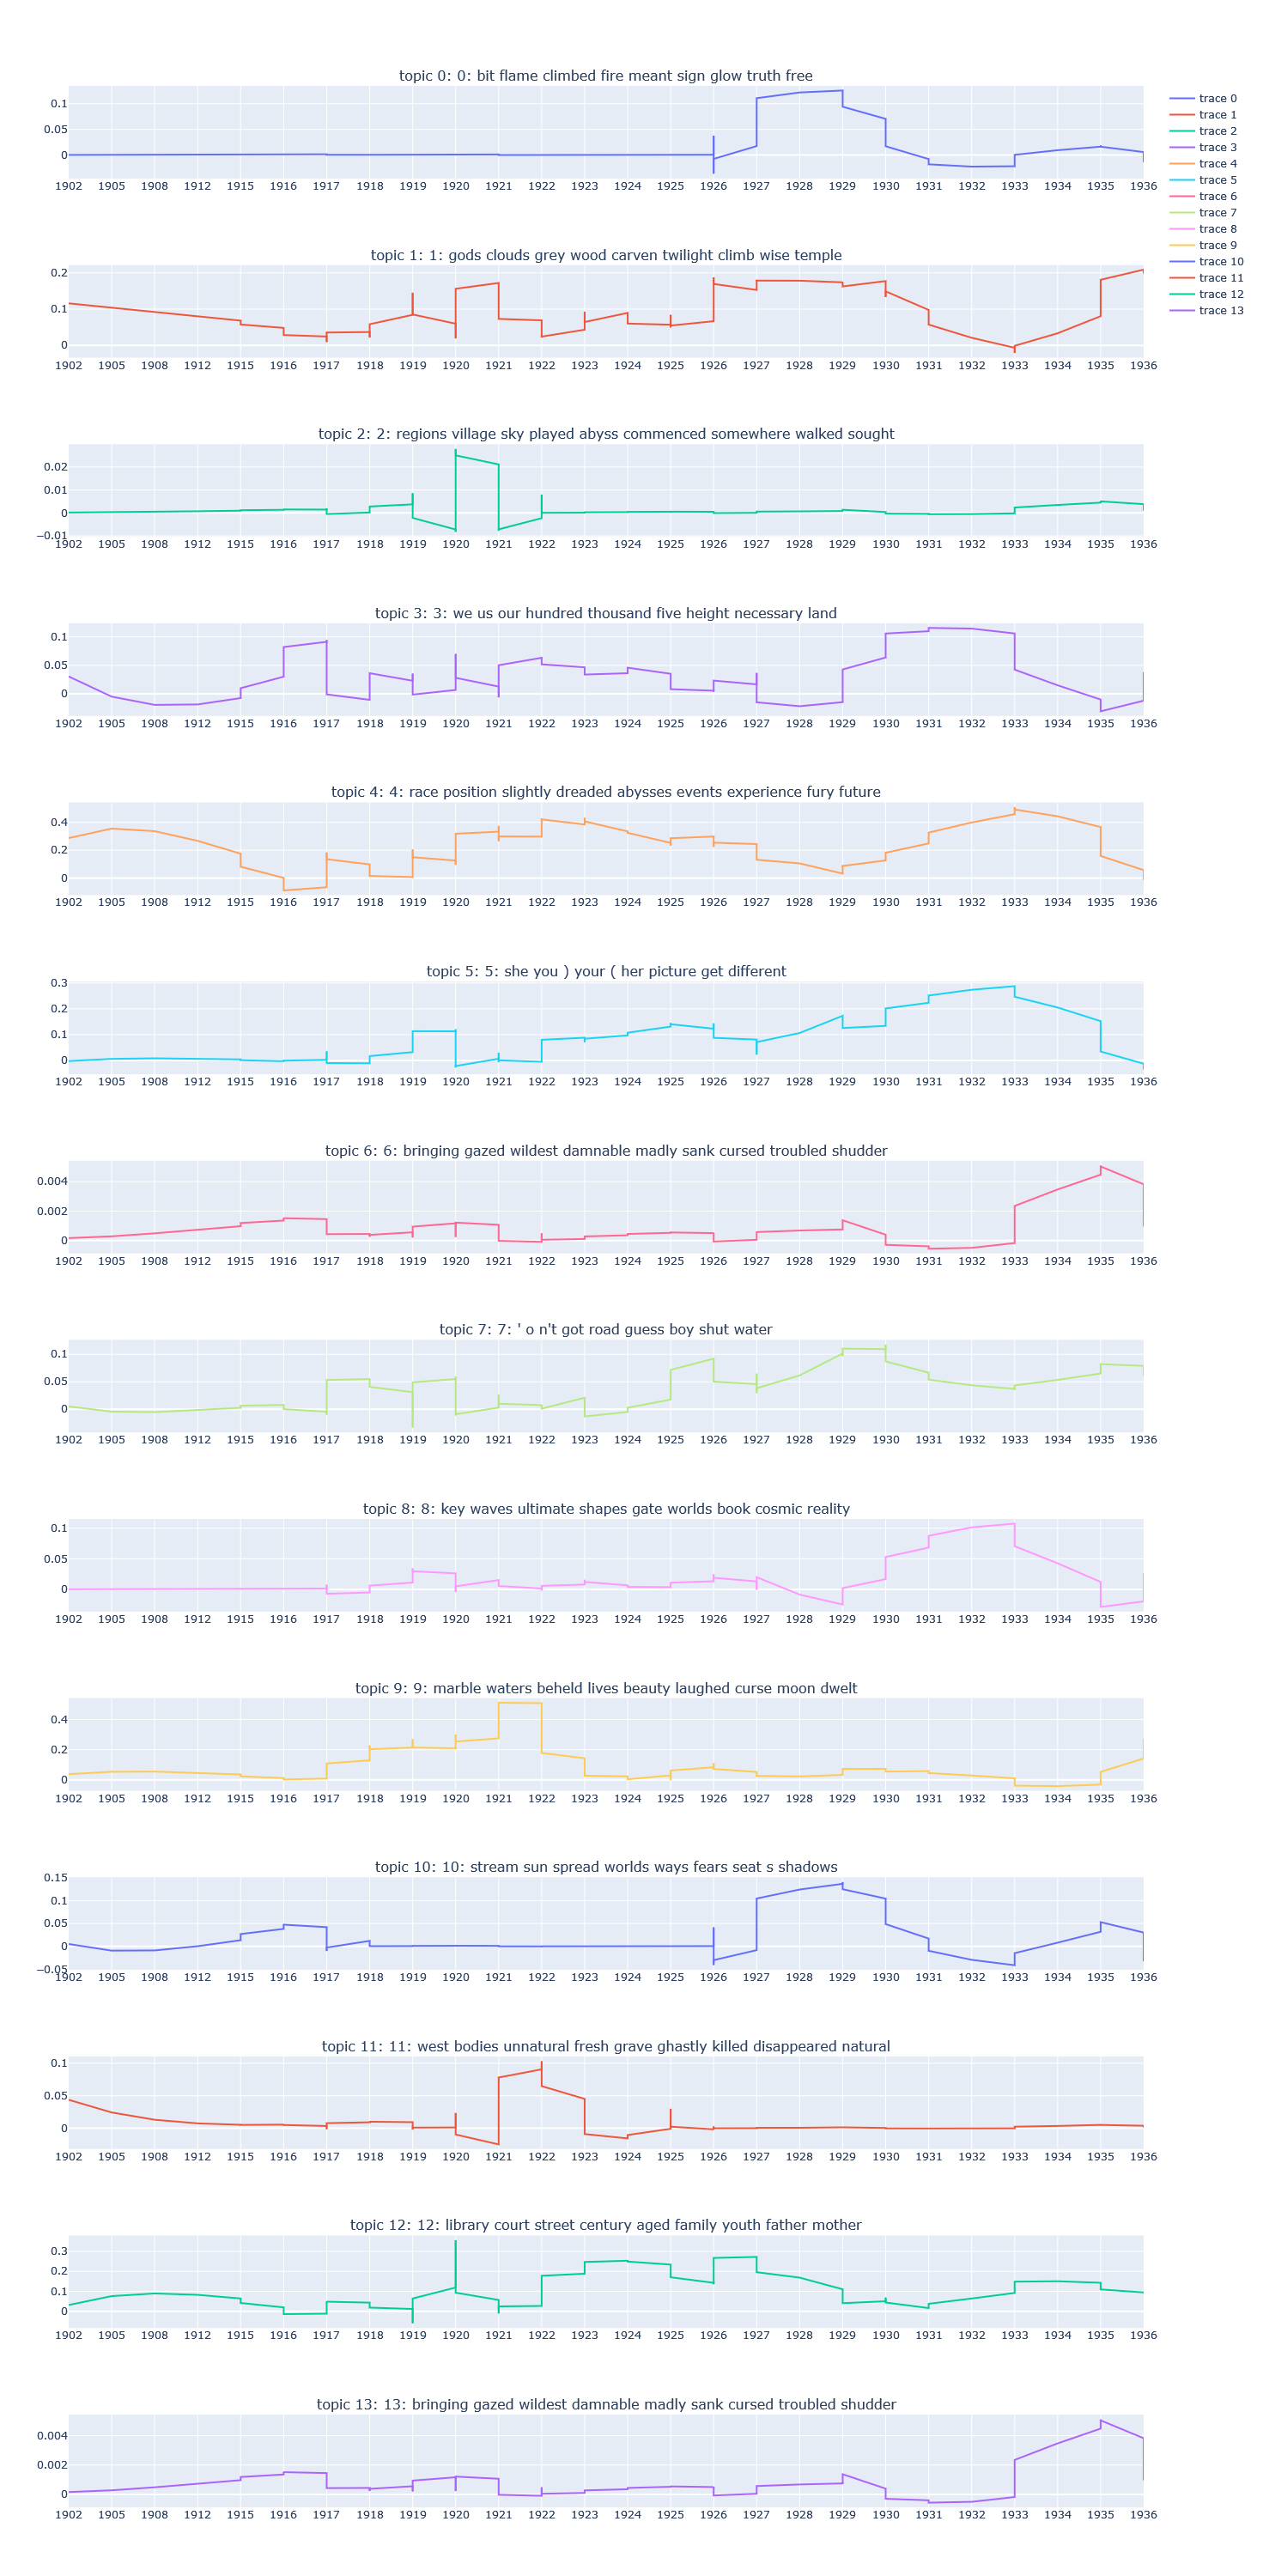

In [357]:
fig.update_layout(height=3000)
fig.show()